In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
import pymc as pm
import pytensor.tensor as pt
import arviz as az

In [ ]:
from IPython.core.pylabtools import figsize

In [ ]:
from scipy.stats.mstats import mquantiles

In [ ]:
iris = sb.load_dataset('iris')

In [ ]:
iris['species'] = iris['species'].astype('category')

In [ ]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species2
0,5.1,3.5,1.4,0.2,setosa,setosa
1,4.9,3.0,1.4,0.2,setosa,setosa
2,4.7,3.2,1.3,0.2,setosa,setosa
3,4.6,3.1,1.5,0.2,setosa,setosa
4,5.0,3.6,1.4,0.2,setosa,setosa


In [ ]:
iris['species2'] = iris['species'].cat.codes

In [ ]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sepal_length  150 non-null    float64 
 1   sepal_width   150 non-null    float64 
 2   petal_length  150 non-null    float64 
 3   petal_width   150 non-null    float64 
 4   species       150 non-null    category
 5   species2      150 non-null    int8    
dtypes: category(1), float64(4), int8(1)
memory usage: 5.2 KB


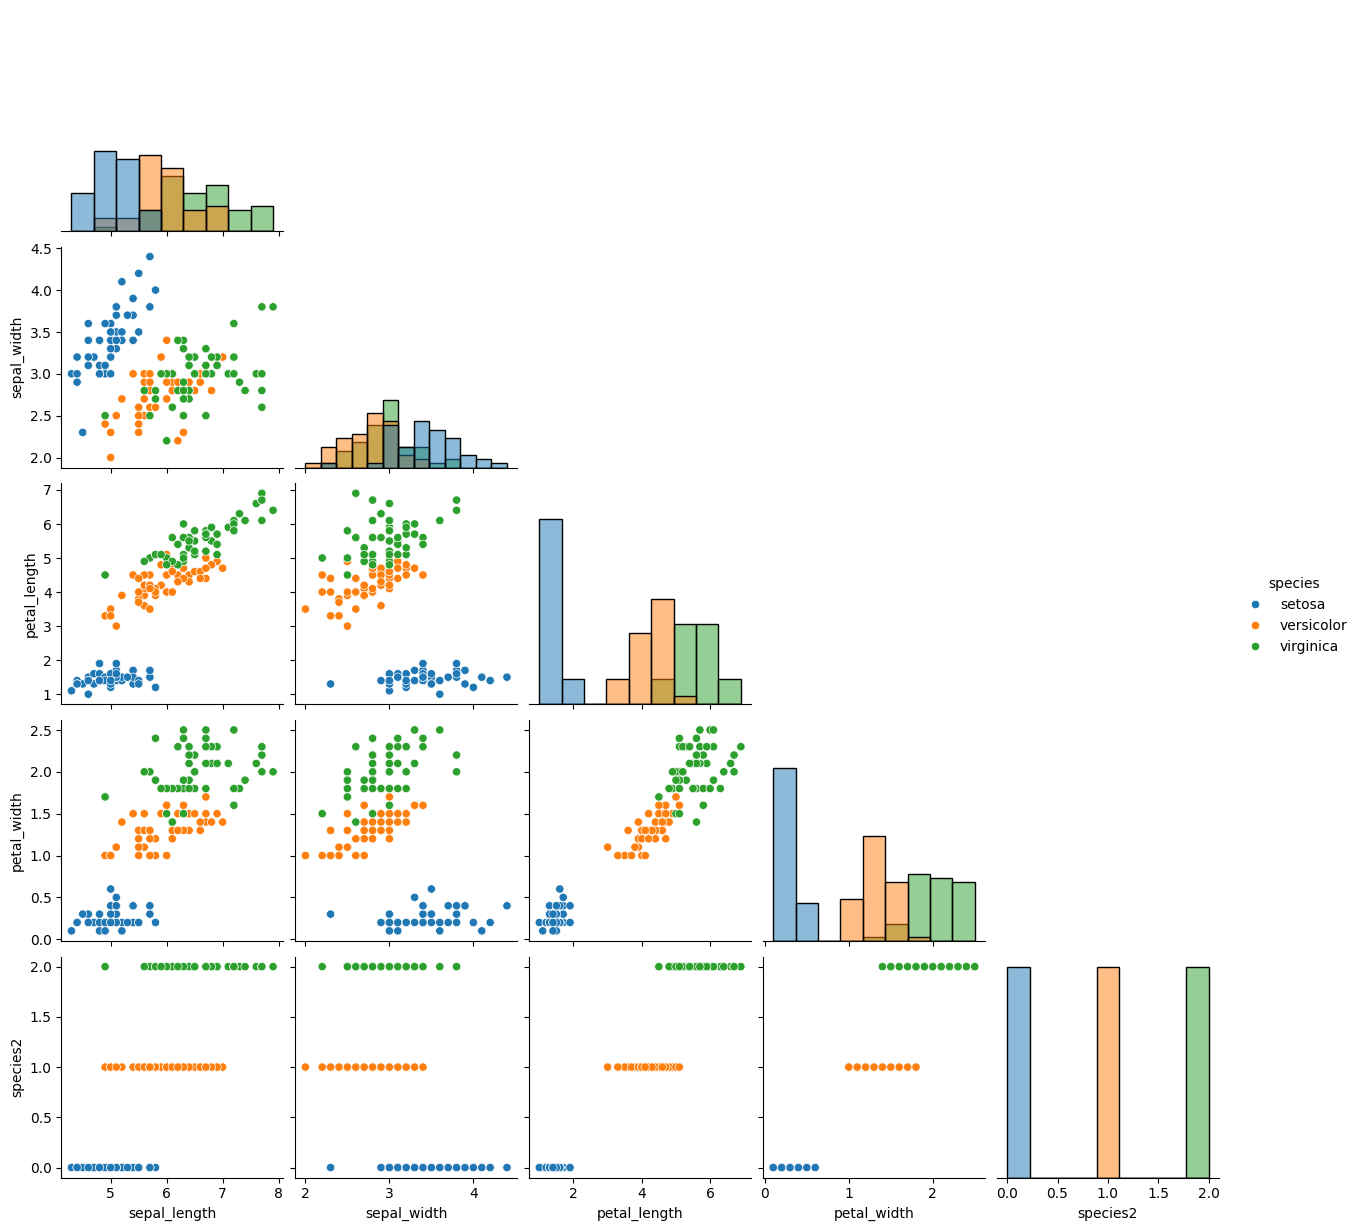

In [ ]:
sb.pairplot(iris, hue='species', diag_kind="hist", corner=True)

In [ ]:
# flip true and false to have setosas on bottom-left
iris['issetosa'] = iris['species'].isin(['setosa']).map({True: 0, False: 1})

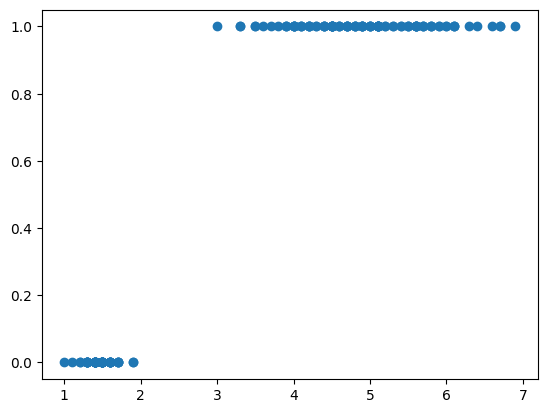

In [ ]:
plt.scatter(iris['petal_length'], iris['issetosa'])

In [ ]:
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, initval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, initval=0)
    p = pm.Deterministic("p", 1.0/(1. + pt.exp(beta * iris['petal_length'] + alpha)))

In [ ]:
with model:
  observed = pm.Bernoulli("bernoulli_obs", p, observed=iris['issetosa'])
  start = pm.find_MAP()
  step = pm.Metropolis()
  trace = pm.sample(120000, step=step, initvals=start)

Output()

Output()

In [ ]:
# best to make them 1d
alpha_samples = np.concatenate(trace.posterior.alpha.data[:,100000::2])[:, None]
beta_samples = np.concatenate(trace.posterior.beta.data[:,100000::2])[:, None]

[]

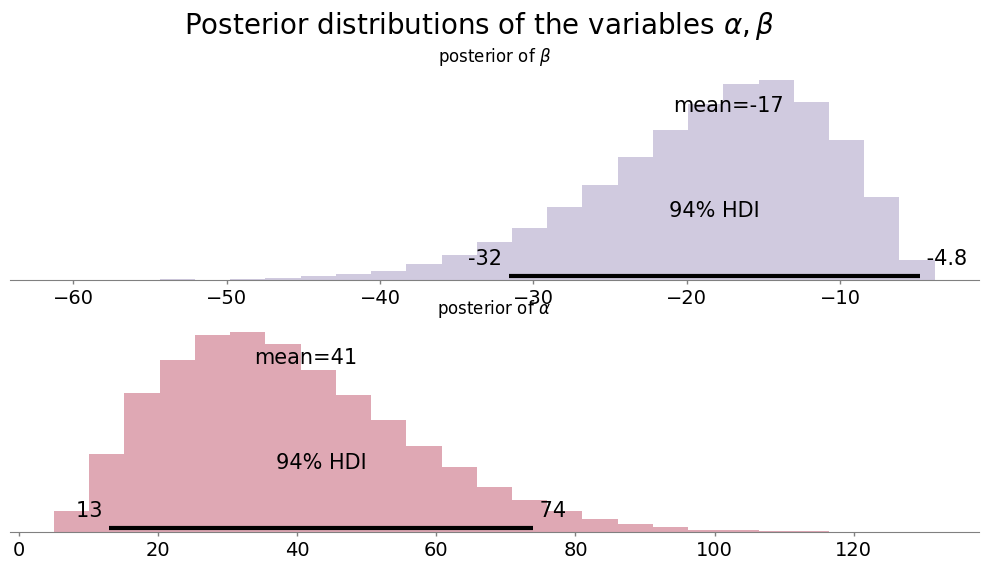

In [ ]:
figure,ax = plt.subplots(2,1)

az.plot_posterior(trace, var_names=['beta'], kind='hist',bins=25,
                  figsize=(12.5,6),color="#7A68A6",ax=ax[0])
az.plot_posterior(trace, var_names=['alpha'], kind='hist',bins=25,
                  figsize=(12.5,6),color="#A60628",ax=ax[1])
plt.suptitle(r"Posterior distributions of the variables $\alpha, \beta$",fontsize=20)
ax[0].set_title(r"posterior of $\beta$")
ax[1].set_title(r"posterior of $\alpha$")
plt.plot()

In the link function, aka the logistic function, beta is the weight and alpha is the bias

So, we get average values for beta and alpha, as well as a standard deviation

In [ ]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

In [ ]:
t = np.linspace(iris['petal_length'].min() - 1, iris['petal_length'].max() + 1, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)
mean_prob_t = p_t.mean(axis=0)

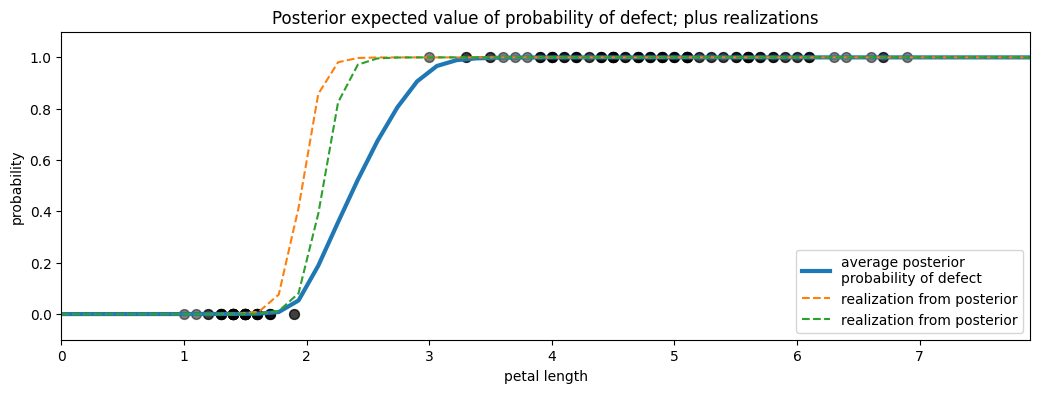

In [ ]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(iris['petal_length'], iris['issetosa'], color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower right")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("petal length");

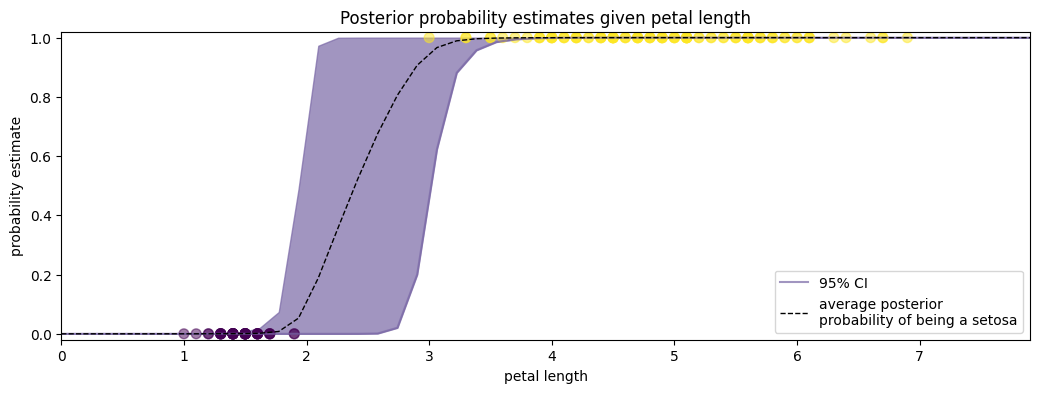

In [ ]:
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of being a setosa")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower right")
#plt.scatter(iris['petal_length'], iris['issetosa'], color="k", s=50, alpha=0.5)
plt.scatter(iris['petal_length'], iris['issetosa'], c=iris['issetosa'], s=50, alpha=0.5)
plt.xlabel("petal length")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given petal length");

The interesting part here is that we know that the uncertainty is maximized where the purple is wide. This is related to the uncertainty shown above for alpha and beta